<a href="https://colab.research.google.com/github/hassiahk/Double-Hard-Debias/blob/main/GloVe_Double_Hard_Debias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import codecs
import json
import operator
from typing import Tuple, Dict, List
import numpy as np
import scipy

%load_ext autoreload
%autoreload 2

### Step 1: Load the GloVe word embeddings

In [2]:
def load_glove_txt(path: str) -> Tuple[np.ndarray, Dict[str, int], List[str]]:
    """
    Loads GloVe embeddings from txt file.
    """

    with open(path, "r", encoding="utf-8") as glove_file:
        lines = glove_file.readlines()

    word_vec = []
    vocab = []

    for line in lines:
        tokens = line.strip().split(" ")

        # `tokens` should be a list of length 301 which consists of the word and the respective 300 dimension word vector
        assert len(tokens) == 301

        vocab.append(tokens[0])
        word_vec.append(tokens[1:])

    word2idx = {word: idx for idx, word in enumerate(vocab)}
    word_vec = np.array(word_vec).astype(float)
    print(f"word_vec shape: {word_vec.shape}, word2idx length: {len(word2idx)}, vocab length: {len(vocab)}")

    return word_vec, word2idx, vocab

word_vec, word2idx, vocab = load_glove_txt('./data/vectors.txt')

word_vec shape: (322636, 300), word2idx length: 322636, vocab length: 322636


### Step 2: Create Male and Female biased word sets

#### Restrict the vocabulary if needed

In [3]:
from utils import limit_vocab


with open('./data/male_word_file.txt') as f:
    gender_specific = [line.strip() for line in f]

with open('./data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

with codecs.open('./data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

definitional_pairs = [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'], ['mother', 'father'], 
    ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male']
]

definitional_words = [word for pair in definitional_pairs for word in pair]

# We will be testing the Double-Hard Debias techique to this subset of words.
# Excluding the gender specific words from this subset.
word_vec_limited, word2idx_limited, vocab_limited = limit_vocab(word_vec, word2idx, vocab, exclude=gender_specific)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 76214.90it/s]


Vocabulary size: 47628


#### Compute original gender bias of a word

In [4]:
# In an ideal case, the gender bias of a word in the vocab_limited should be zero if it is a gender nuetral word
# but this does not happen in a real world scenario.

# Generally, cosine similarity is used to measure how similar two vectors are.
# So, the basic intuition is that if two vectors are similar then the angle and distance between them is 0.
# Distance between two vectors = 1 - similarity of two vectors.

def cosine_similarity(word_vec1: np.ndarray, word_vec2: np.ndarray) -> float:
    """
    Computes Cosine Similarity between two word embeddings or vectors.
    """
    
    # Cosine similarity is nothing but 1 - cosine distance
    return 1 - scipy.spatial.distance.cosine(word_vec1, word_vec2)


# Gender bias of a word is the difference of the word's similarity to `he` word embedding and 
# the word's similarity to `she` word embedding.

def compute_bias(
    word_vec: np.ndarray,
    word2idx: Dict[str, int],
    vocab: List[str],
    he_embed: np.ndarray,
    she_embed: np.ndarray,
) -> Dict[str, float]:
    """
    Computes bias of each word by taking the difference of the word's similarity to `he` word embedding
    and the word's similarity to `she` word embedding.
    """
    
    gender_bias = {}

    for word in vocab:
        vector = word_vec[word2idx[word]]
        # There should not be any difference in 'he' similarity and 'she' similarity for a gender neutral word.
        gender_bias[word] = cosine_similarity(vector, he_embed) - cosine_similarity(vector, she_embed)

    return gender_bias


he_embed = word_vec[word2idx['he']]
she_embed = word_vec[word2idx['she']]

# If this gender bias is > 0 then the word is biased towards male and if < 0 then biased towards female.
gender_bias_original = compute_bias(word_vec_limited, word2idx_limited, vocab_limited, he_embed, she_embed)

In [5]:
gender_bias_original['doctor']

0.012779653811138436

In [6]:
# As you can see here, no word has zero gender bias.        
zero_gender_bias_words = [word for word, bias in gender_bias_original.items() if np.allclose([bias], [0])]
zero_gender_bias_words

[]

#### Creating Male and Female biased word sets

In [7]:
# Sorting gender_bias_original in the ascending order so that all the female biased words will be at the start and
# all the male biased words will be at the end.
biased_words_sorted = sorted(gender_bias_original.items(), key=operator.itemgetter(1))

# Considering 1000 male and 1000 female biased words. 
# size can be anything, the authors mentioned that they took 500 male and 500 female top biased words.
size = 1000
female_words = [word for word, bias in biased_words_sorted[:size]]
male_words = [word for word, bias in biased_words_sorted[-size:]]

### Step 3: Decentralize the word embeddings

In [8]:
word_vec_mean = np.mean(word_vec, axis=0)
word_vec_decentralized = word_vec - word_vec_mean

### Step 4: Compute principal components of decentralized word embeddings using PCA

In [9]:
from sklearn.decomposition import PCA


def principal_component_analysis(word_vec: np.ndarray) -> PCA:
    """
    Performs PCA on decentralized word embeddings.
    """
    
    # Decentalize word embeddings irrespective of whether they are already decentralized because
    # mean of decentralized word embeddings is zero.
    word_vec_mean = np.mean(word_vec, axis=0)
    word_vec_decentralized = word_vec - word_vec_mean

    pca = PCA()
    pca.fit(word_vec_decentralized)
    
    return pca

main_pca = principal_component_analysis(word_vec_decentralized)
# You can access a principal component by main_pca.components_[component_id]

### Step 5: Find and remove frequency and gender directions from the decentralized word embeddings

In [10]:
from utils import perform_pca, remove_vector_component


def frequency_gender_debias(word_vec, word2idx, word2idx_partial, vocab_partial, component_id):
    pricipal_component = main_pca.components_[component_id]
      
    word_vec_frequency = np.zeros((len(vocab_partial), word_vec.shape[1]))

    # Debiasing the embeddings by removing frequency component.
    for word in vocab_partial:
        vector = word_vec[word2idx[word]]
        
        # pricipal_component is a unit vector since all pricipal components are unit vectors.
        # We need to remove the component of vector in the direction of principal_component which is nothing but
        # the projection of vector on principal_component.
        projection = np.dot(np.dot(np.transpose(pricipal_component), vector), pricipal_component)
        word_vec_frequency[word2idx_partial[word]] = vector - projection
    
    # Debiasing the embeddings by removing gender component.
    gender_vector = perform_pca(definitional_pairs, word_vec_frequency, word2idx_partial).components_[0]
    word_vec_debiased = np.zeros((len(vocab_partial), word_vec_frequency.shape[1]))
    
    for word in vocab_partial:
        vector = word_vec_frequency[word2idx_partial[word]]
        word_vec_debiased[word2idx_partial[word]] = remove_vector_component(vector, gender_vector)
        
    return word_vec_debiased

### Step 6: Perform KMeans and evaluate the debiased word embeddings

In [11]:
from sklearn.cluster import KMeans


def cluster_and_evaluate(X, y_true, n_clusters=2, random_state=42) -> Tuple[KMeans, List[int], List[float]]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    y_pred = kmeans.predict(X)
    
    
    result = [1 if target == prediction else 0 for target, prediction in zip(y_true, y_pred)] 
    accuracy = sum(result) / len(result)
    precision = max(accuracy, 1 - accuracy) # Not sure about this
    print(f'Precision: {precision}')
    
    return kmeans, y_pred, precision

### Step 7: Find the optimal frequency direction

In [12]:
def get_embeddings(words, word_vec, word2idx):
    """
    Get embeddings for the given words.
    """
    embeddings = [word_vec[word2idx[word]] for word in words]
    
    return embeddings


y_true = [1] * size + [0] * size

vocab_partial = list(set(male_words + female_words + [word for word in definitional_words if word in word2idx]))
word2idx_partial = {word: idx for idx, word in enumerate(vocab_partial)}

precisions = []

for i in range(20):
    print(f'Component: {i}')
    
    word_vec_debiased = frequency_gender_debias(word_vec_decentralized, word2idx, word2idx_partial, vocab_partial, i)
    kmeans, y_pred, precision = cluster_and_evaluate(
        get_embeddings(male_words + female_words, word_vec_debiased, word2idx_partial), y_true, random_state=1 
    )
    precisions.append(precision)

optimal_frequency_direction = precisions.index(min(precisions))

Component: 0
Pairs used in PCA: 10
Precision: 0.817
Component: 1
Pairs used in PCA: 10
Precision: 0.704
Component: 2
Pairs used in PCA: 10
Precision: 0.8145
Component: 3
Pairs used in PCA: 10
Precision: 0.816
Component: 4
Pairs used in PCA: 10
Precision: 0.802
Component: 5
Pairs used in PCA: 10
Precision: 0.775
Component: 6
Pairs used in PCA: 10
Precision: 0.785
Component: 7
Pairs used in PCA: 10
Precision: 0.8025
Component: 8
Pairs used in PCA: 10
Precision: 0.807
Component: 9
Pairs used in PCA: 10
Precision: 0.815
Component: 10
Pairs used in PCA: 10
Precision: 0.812
Component: 11
Pairs used in PCA: 10
Precision: 0.818
Component: 12
Pairs used in PCA: 10
Precision: 0.8180000000000001
Component: 13
Pairs used in PCA: 10
Precision: 0.8045
Component: 14
Pairs used in PCA: 10
Precision: 0.8145
Component: 15
Pairs used in PCA: 10
Precision: 0.811
Component: 16
Pairs used in PCA: 10
Precision: 0.8145
Component: 17
Pairs used in PCA: 10
Precision: 0.806
Component: 18
Pairs used in PCA: 10
Pr

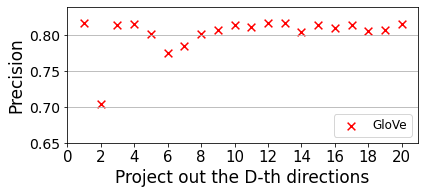

In [13]:
import matplotlib.pyplot as plt


directions = np.arange(1, 21)

fig, ax1 = plt.subplots(figsize=(6,2.8))

color = 'red'
ax1.set_xlabel('Project out the D-th directions', fontsize=17)
ax1.set_ylabel('Precision', fontsize=17)
ax1.scatter(directions, precisions, color=color, label='GloVe', marker = 'x', s=60)
plt.xticks(list(range(0, 21, 2)), fontsize=15)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylim(0.65, 0.84)
ax1.legend(loc='lower right', frameon=True, fontsize='large')
ax1.grid(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Step 8: Double-Hard Debias (Debiasing Frequency and Gender components) the original word embeddings in the optimal frequency direction

In [ ]:
from utils import perform_pca, remove_vector_component

pricipal_component = main_pca.components_[optimal_frequency_direction]

word_vec_frequency = np.zeros((len(vocab), word_vec.shape[1]))

for word in vocab:
    vector = word_vec[word2idx[word]]
    
    projection = np.dot(np.dot(np.transpose(pricipal_component), vector), pricipal_component)
    word_vec_frequency[word2idx[word]] = vector - projection - word_vec_mean

gender_vector = perform_pca(definitional_pairs, word_vec_frequency, word2idx).components_[0]
word_vec_debiased = np.zeros((len(vocab), word_vec_frequency.shape[1]))

for word in vocab:
    vector = word_vec_frequency[word2idx[word]]
    word_vec_debiased[word2idx[word]] = remove_vector_component(vector, gender_vector)